# Airsoft Telemetry Data Analysis

This notebook contains comprehensive analysis of airsoft telemetry data including visualization, movement patterns, and performance insights.

In [1]:
# Import Required Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.collections import LineCollection
import google.generativeai as genai

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\creks\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read Sample Data File
sample_path = './data/sample-1.csv'  # Adjusted path to match the context
df = pd.read_csv(sample_path)

In [3]:
# Show dataframe columns to check for speed
print(df.columns.tolist())

['ID', 'Game Session ID', 'Player ID', 'Event Type', 'Timestamp', 'Date Time', 'Latitude', 'Longitude', 'Altitude', 'Azimuth']


In [4]:
# Clean and prepare data
df = df.iloc[1:].copy()
df.at[df.index[0], 'Event Type'] = 'START'

## Data Visualization

### Basic Telemetry Metrics Over Time

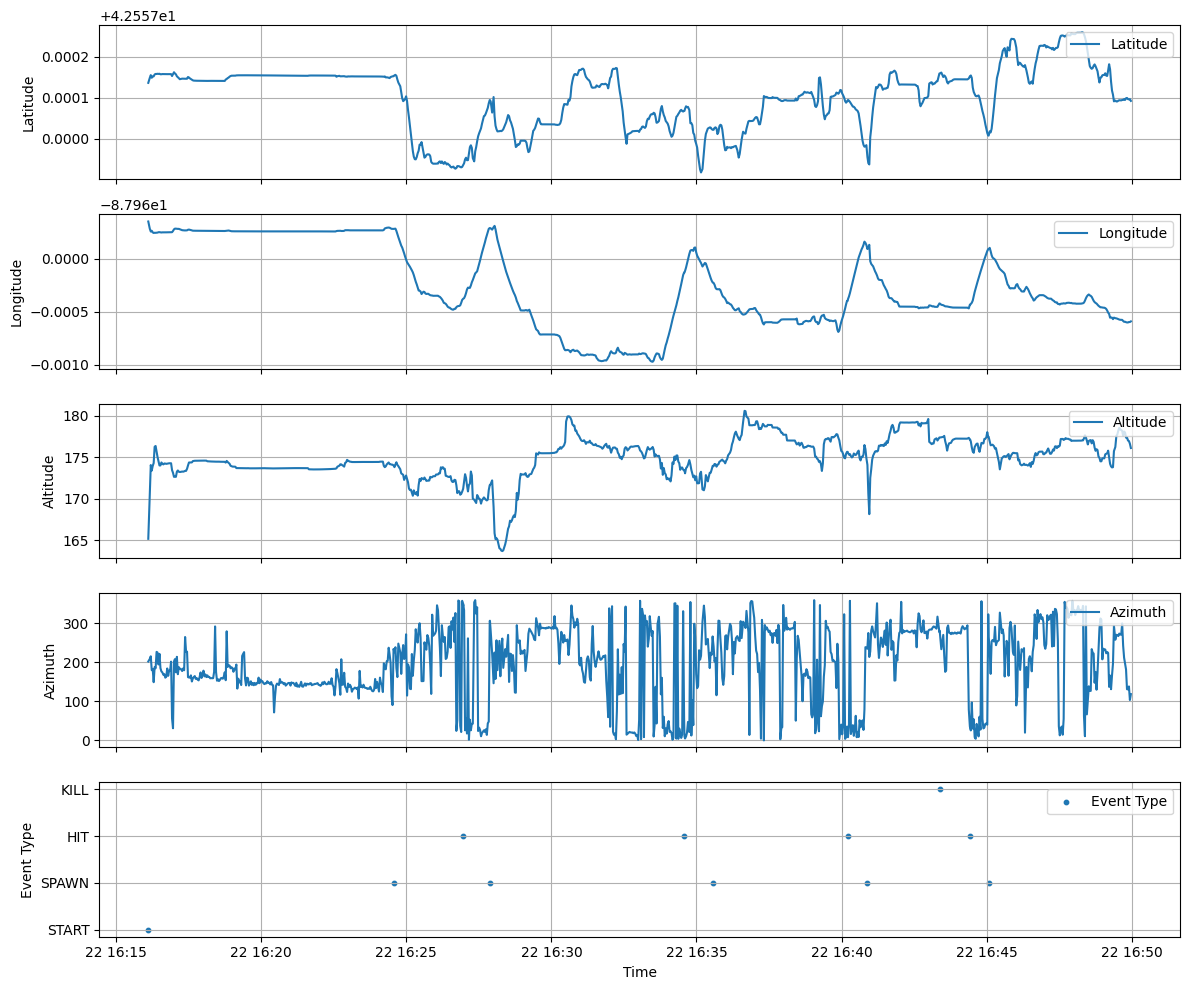

In [5]:
# Remove 'Location' event types from the Event Type chart
metrics = ['Latitude', 'Longitude', 'Altitude', 'Azimuth', 'Event Type']
time = pd.to_datetime(df['Date Time'])

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 10), sharex=True)
for i, metric in enumerate(metrics):
    if metric == 'Event Type':
        mask = df[metric] != 'LOCATION'
        axes[i].scatter(time[mask], df[metric][mask], label=metric, marker='o', s=10)
    else:
        axes[i].plot(time, df[metric], label=metric)
    axes[i].set_ylabel(metric)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

### Altitude Density Visualization

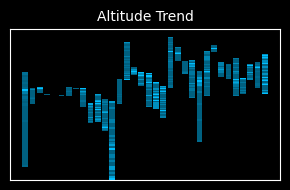

In [6]:
# Group altitude data by 1-minute intervals and plot min/max as bars with vertical brightness based on density (dark mode)

# Ensure 'Date Time' is datetime type
df['Date Time'] = pd.to_datetime(df['Date Time'])

interval = '1T'  # 1-minute intervals
grouped = df.groupby(pd.Grouper(key='Date Time', freq=interval))

alt_min = grouped['Altitude'].min()
alt_max = grouped['Altitude'].max()

plt.style.use('dark_background')
plt.figure(figsize=(3, 2), dpi=100)

num_bins = 40  # Number of vertical bins per bar

for idx, (interval_time) in enumerate(alt_min.index):
    # Get all altitude values in this interval
    altitudes = grouped.get_group(interval_time)['Altitude'] if interval_time in grouped.groups else []
    if len(altitudes) == 0:
        continue
    amin, amax = alt_min[interval_time], alt_max[interval_time]
    bins = np.linspace(amin, amax, num_bins+1)
    counts, _ = np.histogram(altitudes, bins=bins)
    max_count = counts.max() if counts.max() > 0 else 1
    for b in range(num_bins):
        bin_bottom = bins[b]
        bin_top = bins[b+1]
        density = counts[b] / max_count
        # Map density to brightness (0.5 to 1.0 for visibility)
        brightness = 0.5 + 0.5 * density
        color = (0, 191/255 * brightness, 1 * brightness)  # scale blue channel
        plt.bar(idx, bin_top-bin_bottom, bottom=bin_bottom, width=0.8, color=color, edgecolor=None)

plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label
plt.title('Altitude Trend', fontsize=10)   # Add chart title with smaller font
plt.tight_layout()
plt.show()

## AI-Powered Analysis

### Comprehensive Game Analysis using Gemini AI

In [7]:
api_key = os.getenv("GEMINI_API_KEY")

if api_key:
    # Prepare the prompt with all telemetry data
    prompt = (
        "Analyze the following telemetry data from an airsoft game. "
        "Provide insights such as terrain changes, possible player movement patterns, and any anomalies.\n\n"
        "Provide recommendations for improving player performance based on the data.\n\n"
        "Telemetry Data:\n"
    )

    for idx, row in df.iterrows():
        row_str = ', '.join([f"{col}: {row[col]}" for col in df.columns])
        prompt += f"{row['Date Time']}: {row_str}\n"

    # Call Gemini API
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-2.5-flash')
    response = model.generate_content(prompt)

    # Display Gemini's insights
    print(response.text)
else:
    print("GEMINI_API_KEY not found. Skipping AI analysis.")
    response = None

This telemetry data provides a detailed insight into Chris's movement and activity during a segment of an airsoft game.

**Game Session Overview:**
*   **Player:** Chris
*   **Game Session ID:** `006dfa02-7f2f-4c7b-81a5-7367b682e916`
*   **Duration:** From 16:16:06 to 16:49:58 (approximately 33 minutes and 52 seconds of logged activity).
*   **Events:** `START`, `LOCATION` (continuous tracking), `SPAWN` (3 occurrences, suggesting 2 eliminations before the third spawn), `HIT` (3 occurrences), `KILL` (1 occurrence).

---

**I. Analysis and Insights:**

**1. Terrain Changes (Based on Altitude):**

*   **Initial Ascent (16:16:06 - 16:16:11):** Chris starts at an altitude of approximately 165.18 meters and rapidly ascends to 174.06 meters in about 5 seconds. This indicates a very steep incline, likely a hill, a large berm, or a multi-story structure.
*   **First Plateau/Ridge (16:16:11 - 16:24:40):** After the initial climb, Chris generally stays at an altitude between 172m and 176m. There 

In [8]:
if response:
    # Prepare a new prompt for Gemini to generate all concise recommendations for better play
    prompt_recs = (
        "Based on the previous analysis and insights, provide all concise, actionable recommendations for improving airsoft player performance, extracted from the Recommendations section. Format your response as bullet points, each no longer than 128 characters. Try to group similar recommendations together for clarity. Limit the total number of recommendations to 10 or less.\n\n"
        "\n\nAnalysis and Insights:\n"
        + response.text
    )

    # Call Gemini API for recommendations
    response_recs = model.generate_content(prompt_recs)

    # Display Gemini's recommendations
    print("Key Recommendations for Better Play:")
    print(response_recs.text)
else:
    print("No AI analysis available to generate recommendations.")

Key Recommendations for Better Play:
Here are concise, actionable recommendations for improving airsoft player performance, based on the analysis:

*   Immediately relocate to new cover and scan surroundings after a kill.
*   Vary attack angles; utilize wide flanking maneuvers, especially after respawn.
*   Employ feinting tactics to draw fire before repositioning.
*   Optimize static periods: Assess effectiveness; relocate if compromised or ineffective.
*   Coordinate static overwatch with teammates for defensive positions.
*   Master terrain exploitation: Use high ground for overwatch, low ground for concealment.
*   Practice tactical movement drills like bounding overwatch and minimal exposure peeking.
*   Conduct data-driven debriefs to review telemetry and discuss key decisions.


## Player Movement Analysis

### Interactive Map with Player Path

X range: -9791770.778587434 to -9791623.34260105
Y range: 5244771.545643585 to 5244823.358961015


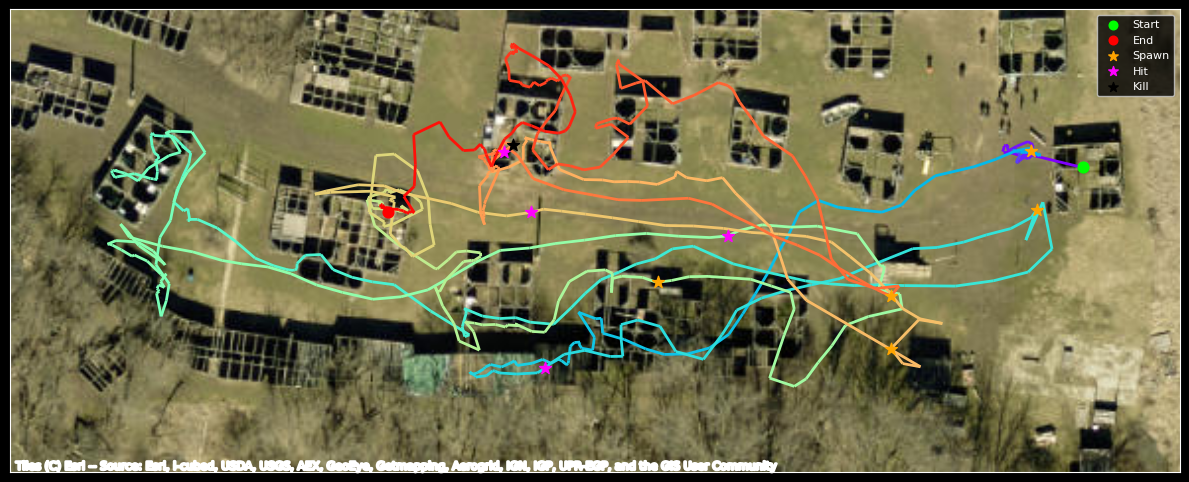

In [9]:
# Convert latitude/longitude to Web Mercator for contextily
df['geometry'] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 6))  # Wider figure to fill available space

# Print coordinate ranges for debugging
print('X range:', gdf['geometry'].x.min(), 'to', gdf['geometry'].x.max())
print('Y range:', gdf['geometry'].y.min(), 'to', gdf['geometry'].y.max())

# Plot the player's path as a rainbow gradient from start to end
x = gdf['geometry'].x.values
y = gdf['geometry'].y.values
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(np.arange(len(segments)))
lc.set_linewidth(2)
ax.add_collection(lc)

# Overlay start and end points
start_handle = ax.scatter(x[0], y[0], color='lime', s=60, label='Start', zorder=2)
end_handle = ax.scatter(x[-1], y[-1], color='red', s=60, label='End', zorder=2)

# Highlight 'spawn', 'hit', and 'kill' events
event_handles = []
event_colors = {'spawn': 'orange', 'hit': 'magenta', 'kill': 'black'}
for event, color in event_colors.items():
    mask = gdf['Event Type'].str.lower() == event
    if mask.any():
        handle = ax.scatter(x[mask], y[mask], color=color, s=80, marker='*', label=event.capitalize(), zorder=3)
        event_handles.append(handle)

# Try satellite/terrain tiles, fallback to Mapnik if blank
try:
    ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.Esri.WorldImagery)
except Exception as e:
    print('Satellite tiles unavailable, using Mapnik:', e)
    ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add more bottom padding to axis limits for watermark visibility
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_pad = (x_max - x_min) * 0.1 if (x_max - x_min) > 0 else 500
y_pad_top = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 500
y_pad_bottom = (y_max - y_min) * 0.25 if (y_max - y_min) > 0 else 1250  # Increased bottom margin for watermark
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad_bottom, y_max + y_pad_top)

ax.set_aspect('equal')
# Remove axis values, ticks, and title
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# Add small legend
ax.legend(loc='upper right', fontsize=8, markerscale=0.8, frameon=True)
plt.tight_layout()
plt.show()

## Game Session Analysis

### Duration and Environmental Conditions

In [10]:
# Summary stats about the length of the game and lighting

# Game length calculation
start_time = df['Date Time'].min()
end_time = df['Date Time'].max()
game_duration = end_time - start_time

print(f"Game Start: {start_time}")
print(f"Game End:   {end_time}")
print(f"Game Duration: {game_duration}")

# Lighting estimation based on timestamps (day/night)
# Assume UTC; for more accuracy, use local timezone and sun position libraries
hour_start = pd.to_datetime(start_time).hour
hour_end = pd.to_datetime(end_time).hour

def lighting_condition(hour):
    if 6 <= hour < 18:
        return "Daylight"
    else:
        return "Low light / Night"

print(f"Lighting at Start: {lighting_condition(hour_start)}")
print(f"Lighting at End:   {lighting_condition(hour_end)}")

Game Start: 2025-06-22 16:16:06.250000
Game End:   2025-06-22 16:49:58.401000
Game Duration: 0 days 00:33:52.151000
Lighting at Start: Daylight
Lighting at End:   Daylight


## Manual Events Analysis

### Event Distribution and Timeline

In [11]:
# Check what event types we have
print("Event type distribution:")
print(df['Event Type'].value_counts())

# Get manual events
manual_events = df[df['Event Type'].isin(['START', 'SPAWN', 'HIT', 'KILL'])].copy()

if len(manual_events) > 0:
    print(f"\nManual Events Timeline:")
    for _, event in manual_events.iterrows():
        print(f"  {event['Date Time']}: {event['Event Type']}")
else:
    print("\nNo manual events found in the data.")

Event type distribution:
Event Type
LOCATION    980
SPAWN         5
HIT           4
START         1
KILL          1
Name: count, dtype: int64

Manual Events Timeline:
  2025-06-22 16:16:06.250000: START
  2025-06-22 16:24:33.506000: SPAWN
  2025-06-22 16:26:57.484000: HIT
  2025-06-22 16:27:52.853000: SPAWN
  2025-06-22 16:34:35.197000: HIT
  2025-06-22 16:35:33.581000: SPAWN
  2025-06-22 16:40:12.753000: HIT
  2025-06-22 16:40:53.545000: SPAWN
  2025-06-22 16:43:23.008000: KILL
  2025-06-22 16:44:26.105000: HIT
  2025-06-22 16:45:04.280000: SPAWN


## Performance Summary

This analysis provides insights into:
- Player movement patterns and paths
- Game duration and environmental conditions  
- Manual event distribution
- AI-generated performance recommendations

The data can be used to:
- Improve tactical awareness
- Analyze team positioning
- Review engagement patterns
- Optimize future gameplay strategies